In [114]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from util.load_scenarios import load_scenario_df
from util.load_evaluations import load_rs_df, load_ver_df

# Load data


In [115]:
RS_PATH = "../data/evaluation/random_search"

rs_df = load_rs_df(RS_PATH)
rs_df = rs_df.reset_index().set_index(
    ['fps', 'highquality', 'rep', 'it', 'route_id'])


scenario_df = load_scenario_df("../data/definition/rs_routes.xml")

rs_df = rs_df.join(scenario_df, on='route_index', how='inner').sort_index()

# verification set is becoming a
ver_df = load_ver_df(RS_PATH + "/rs_v3/verification").set_index(
    'route_id')

## Load model


In [116]:

with open("model.pkl", "rb") as f:
    model = pickle.load(f)

# PROCESS DATA


## Predict fidelity robustness


In [117]:
def do_prediction(rs_trace, model, features=['max_angles', 'dist_len_ratio', 'n_turns']):
    X = rs_trace[features].to_numpy()
    rs_trace['prediciton'] = model.predict(X)
    return rs_trace


rs_trace = rs_df.copy().xs(("10", "True"), drop_level=False).sort_index()
rs_trace = do_prediction(rs_trace, model)
rs_trace['prediciton'].value_counts()

prediciton
risky    686
safe      64
Name: count, dtype: int64

**! very important here**
Here in 10FPS epic we have deemed 64 safe runs so they will be using low fid.
The rest of risky scenarios (686) will use high fidelity


to substitute running for risky scenario swap with 20Fid executions which is in verification set


## Fuse fidelities


In [118]:
def do_fidelity_fusion(rs_trace):
    # makes sense in case of classifier
    processed_batches = []

    # iterate over prediction classes
    for prediciton, batch in rs_trace.groupby('prediciton'):
        match prediciton:
            case 'safe':
                # do nothihg if scenario is safe to run
                batch['swapped'] = 'no'
                pass
            case 'risky':

                # use verification data set as high fidelity
                high_fid = ver_df

                # if scenario is risky swap with HF data from verification set
                high_fid = high_fid[['driving_score', 'duration_system']]
                batch = batch.drop(
                    ['driving_score', 'duration_system'], axis=1)
                batch = batch.join(high_fid, on='route_id')
                batch['swapped'] = 'yes'

        processed_batches.append(batch)

    mff_trace = pd.concat(processed_batches).sort_index()
    return mff_trace


mff_trace = do_fidelity_fusion(rs_trace)

## Compute solutions of trace

random search


In [119]:
def get_solutions_of_iteration(rs_trace, curr_it):

    idx = pd.IndexSlice
    # get slice of data frame from iteration 0 to current iteration
    slice = rs_trace.loc[idx[:, :, :, :curr_it], :]

    # get index of minumum driving score -> solution (in iterations so far)
    gb = slice.groupby(['fps', 'highquality', 'rep',])[
        'driving_score']

    solutions_idx = gb.idxmin().rename('solution_idx')

    # get value of minimum driving score
    solutions_score = gb.min().rename('solution_score')

    solutions = pd.concat([solutions_idx, solutions_score], axis=1)
    solutions['it'] = curr_it
    solutions = solutions.reset_index().set_index(
        ['fps', 'highquality', 'rep', 'it'])

    return solutions

In [120]:
# get_solutions_of_iteration(mff_trace, 0)

In [121]:
def get_solutions_from_trace(rs_trace: pd.DataFrame) -> pd.DataFrame:

    NUM_OF_ITERAITONS = 25

    sols_df = pd.concat([get_solutions_of_iteration(rs_trace, it)
                        for it in range(NUM_OF_ITERAITONS)], axis=0)

    # at what iteration did we find the solution
    sols_df['solution_it'] = sols_df['solution_idx'].apply(lambda x: x[-2])
    # what is the route_id of the solution
    sols_df['solution_route_id'] = sols_df['solution_idx'].apply(
        lambda x: x[-1])

    # we don't need that once unpacked
    # sols_df = sols_df.drop('solution_idx', axis=1)

    # add data from verification
    oracle_df = ver_df['driving_score'].rename("oracle_dscore")
    sols_df = sols_df.join(oracle_df, on='solution_route_id')
    sols_df = sols_df.sort_index()
    return sols_df


mff_sols = get_solutions_from_trace(mff_trace)
# sols_df

## Add cumulative time


In [122]:
def get_cumulative_time_from_trace(rs_trace: pd.DataFrame) -> pd.Series:
    cumulative_time = (rs_trace['duration_system']
                       .groupby(['fps', 'highquality', 'rep'])
                       .cumsum()
                       .rename('cumulative_time'))

    return cumulative_time


ct = get_cumulative_time_from_trace(rs_trace)
mff_sols = mff_sols.join(ct)

In [123]:
mff_sols

solution_idx  \
fps highquality rep it route_id                                                   
10  True        0   0  RouteScenario_88      (10, True, 0, 0, RouteScenario_88)   
                    1  RouteScenario_744     (10, True, 0, 0, RouteScenario_88)   
                    2  RouteScenario_718     (10, True, 0, 0, RouteScenario_88)   
                    3  RouteScenario_317    (10, True, 0, 3, RouteScenario_317)   
                    4  RouteScenario_611    (10, True, 0, 3, RouteScenario_317)   
...                                                                         ...   
                29  20 RouteScenario_696   (10, True, 29, 3, RouteScenario_142)   
                    21 RouteScenario_544  (10, True, 29, 21, RouteScenario_544)   
                    22 RouteScenario_451  (10, True, 29, 21, RouteScenario_544)   
                    23 RouteScenario_14   (10, True, 29, 21, RouteScenario_544)   
                    24 RouteScenario_658  (10, True, 29, 21, RouteScenario_544)   

                                          solution_score  solution_it  \
fps highquality rep it route_id                                         
10  True        0   0  RouteScenario_88         0.984344            0   
                    1  RouteScenario_744        0.984344            0   
                    2  RouteScenario_718        0.984344            0   
                    3  RouteScenario_317        0.941897            3   
                    4  RouteScenario_611        0.941897            3   
...                                                  ...          ...   
                29  20 RouteScenario_696        0.452185            3   
                    21 RouteScenario_544        0.161731           21   
                    22 RouteScenario_451        0.161731           21   
                    23 RouteScenario_14         0.161731           21   
                    24 RouteScenario_658        0.161731           21   

                                          solution_route_id  oracle_dscore  \
fps highquality rep it route_id                                              
10  True        0   0  RouteScenario_88    RouteScenario_88       0.984344   
                    1  RouteScenario_744   RouteScenario_88       0.984344   
                    2  RouteScenario_718   RouteScenario_88       0.984344   
                    3  RouteScenario_317  RouteScenario_317       0.941897   
                    4  RouteScenario_611  RouteScenario_317       0.941897   
...                                                     ...            ...   
                29  20 RouteScenario_696  RouteScenario_142       0.452185   
                    21 RouteScenario_544  RouteScenario_544       0.161731   
                    22 RouteScenario_451  RouteScenario_544       0.161731   
                    23 RouteScenario_14   RouteScenario_544       0.161731   
                    24 RouteScenario_658  RouteScenario_544       0.161731   

                                          cumulative_time  
fps highquality rep it route_id                            
10  True        0   0  RouteScenario_88        493.262429  
                    1  RouteScenario_744      1043.992181  
                    2  RouteScenario_718      1421.828192  
                    3  RouteScenario_317      2541.361012  
                    4  RouteScenario_611      3070.621674  
...                                                   ...  
                29  20 RouteScenario_696     11900.527953  
                    21 RouteScenario_544     12352.614451  
                    22 RouteScenario_451     12982.170370  
                    23 RouteScenario_14      13472.228108  
                    24 RouteScenario_658     14100.488308  

[750 rows x 6 columns]

In [124]:
def average_repetitions(sols_df: pd.DataFrame):

    return (sols_df
            .select_dtypes('number')
            .groupby(['fps', 'highquality', 'it'])
            .mean())

In [125]:
mff_sols = average_repetitions(mff_sols)
# mff_sols

<Axes: xlabel='cumulative_time', ylabel='oracle_dscore'>

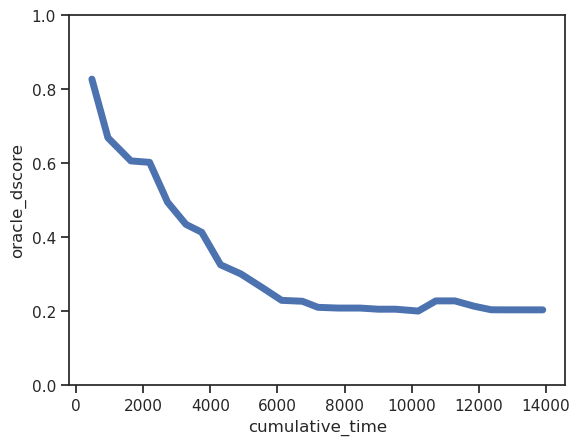

In [126]:
f, ax = plt.subplots()
ax.set_ylim(0, 1)

sns.lineplot(data=mff_sols,  x='cumulative_time',
             y='oracle_dscore', ax=ax,  errorbar=None, lw=5)

In [127]:
def process_rs_df(rs_df):
    rs_df = rs_df.reset_index().set_index(
        ['fps', 'highquality', 'rep', 'it', 'route_id'])

    # get solutions at each iterations
    sols_df = get_solutions_from_trace(rs_df)

    # calculate cumulative time of iterations
    cumulative_time = get_cumulative_time_from_trace(rs_df)
    sols_df = sols_df.join(cumulative_time)

    # average repetitions
    sols_df = average_repetitions(sols_df)
    return sols_df

In [128]:
old_rs = load_rs_df(RS_PATH)
old_sols_df = process_rs_df(old_rs)

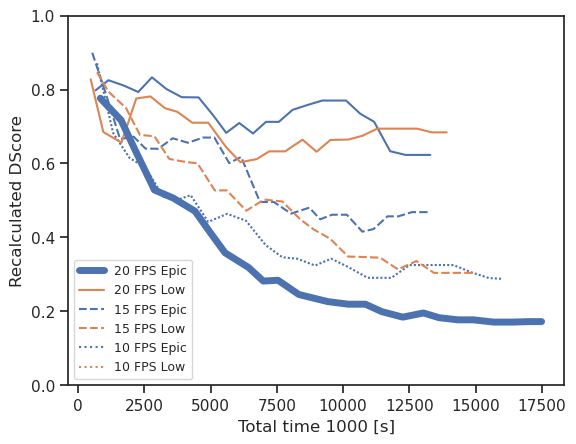

In [129]:
def plot_solutions(sols_df):
    sns.set_theme(style="ticks", palette="deep")

    f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

    sns.lineplot(data=sols_df, x='cumulative_time', y='oracle_dscore',
                 style='fps', hue='highquality', ax=ax, errorbar=None)

    sns.lineplot(data=sols_df.xs(("20", "True"), level=['fps', 'highquality'], drop_level=False),  x='cumulative_time',
                 y='oracle_dscore', hue='highquality', ax=ax,  errorbar=None, lw=5)

    ax.set_ylabel("Recalculated DScore")
    ax.set_xlabel("Total time 1000 [s]")
    ax.set_ylim(0, 1)

    # BETTER LEGEND
    handles, labels = ax.get_legend_handles_labels()

    blue = handles[1].get_color()
    orange = handles[2].get_color()
    lines = [
        mlines.Line2D([], [], color=blue, linestyle=None,
                      label='20 FPS Epic', lw=5),
        mlines.Line2D([], [], color=orange,
                      linestyle=None, label='20 FPS Low'),

        mlines.Line2D([], [], color=blue, linestyle='--', label='15 FPS Epic'),
        mlines.Line2D([], [], color=orange,
                      linestyle='--', label='15 FPS Low'),
        mlines.Line2D([], [], color=blue, linestyle='dotted',
                      label='10 FPS Epic'),
        mlines.Line2D([], [], color=orange,
                      linestyle='dotted', label='10 FPS Low'),

    ]

    ax.legend(handles=lines, prop={'size': 9})

    # f.savefig('plot_rq3.pdf', bbox_inches='tight')


plot_solutions(process_rs_df(old_rs))

# PLOT


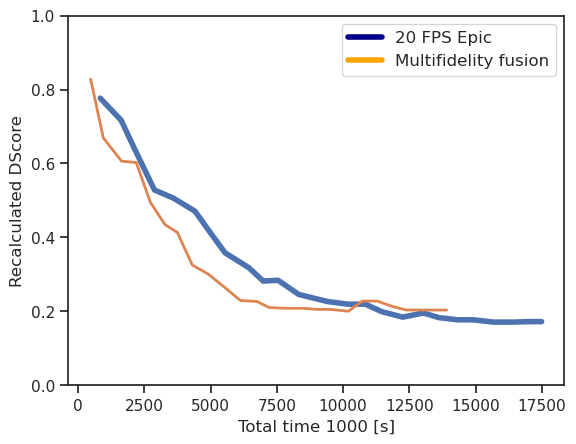

In [130]:

sns.set_theme(style="ticks", palette="deep")

f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

# sns.lineplot(data=average_sols_df(old_sols_df),  x='cumulative_time',
#              y='oracle_dscore', style='fps',  hue='highquality', ax=ax,  errorbar=None)

sns.lineplot(data=average_repetitions(old_sols_df).xs(("20", "True")),  x='cumulative_time',
             y='oracle_dscore', ax=ax,  errorbar=None, lw=4)

sns.lineplot(data=mff_sols,  x='cumulative_time',
             y='oracle_dscore', ax=ax,  errorbar=None, lw=2)


ax.set_ylabel("Recalculated DScore")
ax.set_xlabel("Total time 1000 [s]")
ax.set_ylim(0, 1)

lines = [
    mlines.Line2D([], [], color="darkblue", lw=4,
                  label='20 FPS Epic'),
    mlines.Line2D([], [], color="orange", lw=4,

                  label='Multifidelity fusion'),
]
ax.legend(handles=lines, prop={'size': 12})
f.savefig('plot.pdf', bbox_inches='tight')

## Statistical tests


In [131]:
from scipy.stats import mannwhitneyu
from itertools import permutations

In [132]:
column = 'cumulative_time'

mff_list = mff_sols[column].groupby('it').agg(list)
high_fid_list = old_sols_df.xs(("20", "True"))[column].groupby('it').agg(list)

In [133]:
def do_test(fid_a, fid_b, set_a, set_b, confidence_level=0.95):
    U1, p = mannwhitneyu(set_a, set_b)

    max_error = 1 - confidence_level

    if p < max_error:
        print(
            f"\tThe difference beetween {fid_a} and {fid_b} IS statistically significant. {p=:.5f}")
        print(set_a)
        print(set_b)
    else:
        # return
        print(
            f"\tThe difference beetween {fid_a} and {fid_b} is NOT statistically significant. {p=:.5f}")

In [134]:
# # iterate over all possible fidelities
# ITERATION = 0
# a = old_sols_df.xs(("20", "True"))
# b = sols_df.xs(("10", "True"))
# for x in b.itertuples():
#     print(x)

In [135]:
for mf, hf in zip(mff_list, high_fid_list):
    do_test("MFF", "High fid", mf, hf)

	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT stati